In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

/home/tech/Hawon/dacon-jump-ai-2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle('../data/250714_preprocessed_HW_V2.pkl')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25753 entries, 0 to 25752
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   smiles           25753 non-null  object 
 1   ic50_nm          3913 non-null   float64
 2   ic50_nm_imputed  25753 non-null  float64
 3   is_active(10um)  25374 non-null  object 
 4   data_source      25753 non-null  object 
 5   data_id          25753 non-null  object 
 6   pvalue           3913 non-null   float64
 7   pvalue_imputed   25753 non-null  float64
 8   rdmol            25753 non-null  object 
 9   rdmol_confs5     25753 non-null  object 
 10  medai_id         25753 non-null  object 
dtypes: float64(4), object(7)
memory usage: 2.2+ MB


,smiles,ic50_nm,ic50_nm_imputed,is_active(10um),data_source,data_id,pvalue,pvalue_imputed,rdmol,rdmol_confs5,medai_id
0,BrC1=C2C(=C(Br)C(Br)=C1Br)N=C(NCCCN)N2,130.000000,130.000000,True,CAS,"N1-(4,5,6,7-Tetrabromo-1H-benzimidazol-2-yl)-1...",6.886057,6.886057,<rdkit.Chem.rdchem.Mol object at 0x78e2204d8630>,<rdkit.Chem.rdchem.Mol object at 0x78e21aee3380>,Medai_00000
1,BrC1=C2C(N=C(NCCCNC(CCC(N[C@H](C(N[C@H](C(N[C@...,25.000000,25.000000,True,CAS,nan,7.602060,7.602060,<rdkit.Chem.rdchem.Mol object at 0x78e2205fd120>,<rdkit.Chem.rdchem.Mol object at 0x78e21aee33d0>,Medai_00001
2,BrC1=C2C=3C(=C(NC(=O)C4=CC(=C(C)C=C4F)N5C=C(N=...,39.800000,39.800000,True,CAS,"N-(1-Bromo-5,6-dihydroimidazo[1,5-d][1,4]benzo...",7.400117,7.400117,<rdkit.Chem.rdchem.Mol object at 0x78e2205fd210>,<rdkit.Chem.rdchem.Mol object at 0x78e21aee3420>,Medai_00002
3,BrC1=CN(C=2C1=CN=C(NC(=O)C3=CC=C([C@@](CO)(C)O...,7.000000,7.000000,True,CAS,"N-(3-Bromo-1-cyclopropyl-1H-pyrrolo[3,2-c]pyri...",8.154902,8.154902,<rdkit.Chem.rdchem.Mol object at 0x78e2205fd2b0>,<rdkit.Chem.rdchem.Mol object at 0x78e21aee3470>,Medai_00003
4,BrC=1C2=C(N=CN=C2NC1)N3CCC(N(C(=O)C=4C=CN=CC4)...,89.125367,89.125367,True,CAS,"N-[1-(5-Bromo-7H-pyrrolo[2,3-d]pyrimidin-4-yl)...",7.049999,7.049999,<rdkit.Chem.rdchem.Mol object at 0x78e2205fd440>,<rdkit.Chem.rdchem.Mol object at 0x78e21aee34c0>,Medai_00004


### 1. 데이터 분포 확인

In [3]:
smiles_df = df['smiles']
smiles_list = smiles_df.tolist()

In [4]:
lengths = [len(s) for s in smiles_list]
print("max 길이:", max(lengths))
print("avg 길이:", sum(lengths)/len(lengths))
p99 = int(np.percentile(lengths, 99))
print(f"99% SMILES는 길이: {p99}")

max 길이: 164
avg 길이: 59.86859783326214
99% SMILES는 길이: 101


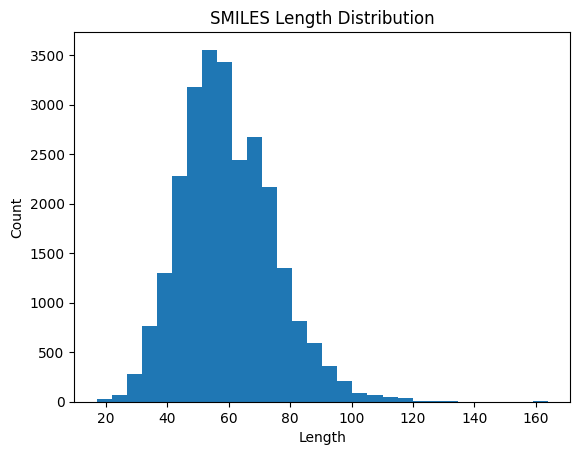

In [5]:
plt.hist(lengths, bins=30)
plt.title("SMILES Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

### 2. ChemBERTa embedding

In [6]:
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
MAX_LEN = 256
embedding_list = []
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model.to(device)
model.eval()

inputs = tokenizer(
    smiles_list,
    max_length=MAX_LEN,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state     
    mol_embeddings = last_hidden[:, 0, :]          

embedding_list = mol_embeddings.cpu().numpy().tolist()
df['embedding'] = embedding_list

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.43 GiB. GPU 1 has a total capacity of 39.39 GiB of which 119.25 MiB is free. Process 3013100 has 416.00 MiB memory in use. Process 742152 has 490.00 MiB memory in use. Including non-PyTorch memory, this process has 38.37 GiB memory in use. Of the allocated memory 37.89 GiB is allocated by PyTorch, and 8.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

,smiles,ic50_nm,ic50_nm_imputed,is_active(10um),data_source,data_id,pvalue,pvalue_imputed,rdmol,medai_id,embedding
0,BrC1=C2C(=C(Br)C(Br)=C1Br)N=C(NCCCN)N2,130.000000,130.000000,True,CAS,"N1-(4,5,6,7-Tetrabromo-1H-benzimidazol-2-yl)-1...",6.886057,6.886057,<rdkit.Chem.rdchem.Mol object at 0x7f06da9d7a10>,Medai_00000,"[0.0653422400355339, 0.21683062613010406, 0.00..."
1,BrC1=C2C(N=C(NCCCNC(CCC(N[C@H](C(N[C@H](C(N[C@...,25.000000,25.000000,True,CAS,nan,7.602060,7.602060,<rdkit.Chem.rdchem.Mol object at 0x7f06da9d7ab0>,Medai_00001,"[-0.6916883587837219, -0.3020058870315552, -0...."
2,BrC1=C2C=3C(=C(NC(=O)C4=CC(=C(C)C=C4F)N5C=C(N=...,39.800000,39.800000,True,CAS,"N-(1-Bromo-5,6-dihydroimidazo[1,5-d][1,4]benzo...",7.400117,7.400117,<rdkit.Chem.rdchem.Mol object at 0x7f06da9d7b50>,Medai_00002,"[0.07351342588663101, -0.06333830207586288, -0..."
3,BrC1=CN(C=2C1=CN=C(NC(=O)C3=CC=C([C@@](CO)(C)O...,7.000000,7.000000,True,CAS,"N-(3-Bromo-1-cyclopropyl-1H-pyrrolo[3,2-c]pyri...",8.154902,8.154902,<rdkit.Chem.rdchem.Mol object at 0x7f06da9d7ce0>,Medai_00003,"[-0.1934972107410431, 0.20120902359485626, -0...."
4,BrC=1C2=C(N=CN=C2NC1)N3CCC(N(C(=O)C=4C=CN=CC4)...,89.125367,89.125367,True,CAS,"N-[1-(5-Bromo-7H-pyrrolo[2,3-d]pyrimidin-4-yl)...",7.049999,7.049999,<rdkit.Chem.rdchem.Mol object at 0x7f06da8eacf0>,Medai_00004,"[-0.09153597801923752, -0.1373140513896942, -0..."
...,...,...,...,...,...,...,...,...,...,...,...
25748,c1cc(-c2n[nH]c3ccc(-c4nncn4C4CCCCC4)cc23)cc(-n...,243.000000,243.000000,True,CHEMBL,CHEMBL4878127,6.614394,6.614394,<rdkit.Chem.rdchem.Mol object at 0x7f06ca4a7240>,Medai_25748,"[0.13545580208301544, 0.07915136218070984, 0.0..."
25749,c1ccc(Nc2ncc3cc(-c4cn[nH]c4)ccc3n2)cc1,10000.000000,10000.000000,False,CHEMBL,CHEMBL4213241,5.000000,5.000000,<rdkit.Chem.rdchem.Mol object at 0x7f06ca4f7290>,Medai_25749,"[0.0358232706785202, 0.13327224552631378, 0.01..."
25750,c1ccc(Nc2ncc3ccccc3n2)cc1,10000.000000,10000.000000,False,CHEMBL,CHEMBL1644356,5.000000,5.000000,<rdkit.Chem.rdchem.Mol object at 0x7f06ca4f72e0>,Medai_25750,"[0.13491997122764587, 0.15450438857078552, 0.0..."
25751,c1ccc(Nc2ncnc3[nH]cnc23)cc1,10000.000000,10000.000000,False,CHEMBL,CHEMBL359730,5.000000,5.000000,<rdkit.Chem.rdchem.Mol object at 0x7f06ca517330>,Medai_25751,"[0.08395140618085861, 0.11996915936470032, 0.0..."


In [12]:
df.to_pickle("250715_smiles_1d_embeddings.pkl")

In [13]:
torch.save(mol_embeddings, "chemberta_embeddings.pt")